**Model Source:**<br />
https://github.com/kuangliu/pytorch-cifar/blob/49b7aa97b0c12fe0d4054e670403a16b6b834ddd/models/dla_simple.py

# Setup Variables

In [9]:
DATASET = 'Cifar10'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [10]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring-2':
    os.chdir('../../..')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring-2')

# Libraries

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import json
from fastprogress import progress_bar, master_bar

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [12]:
from utilities.utils import *
from utilities.pathManager import fetchPaths

from models.cifar10_dla import Cifar10_DLA as model_

# Paths

In [13]:
paths = fetchPaths(base, DATASET, '', False)

path_data = paths['data']
path_model = paths['model']
path_saved_model = paths['saved_models']
path_bdd = paths['bdd']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']
configs = load_json(paths['configuration'])
bdd_configs = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']

# GPU Device & Seed

In [14]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [15]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Load / Split / DataLoader

In [16]:
feature_names = get_labels(DATASET)

# IMPORTANT Augmentation
tf_train = T.Compose([
    T.ToTensor(),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

tf_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


train_data = get_dataset(DATASET, path_data, train=True, transform=tf_train)
test_data = get_dataset(DATASET, path_data, train=False, transform=tf_test)
len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [17]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

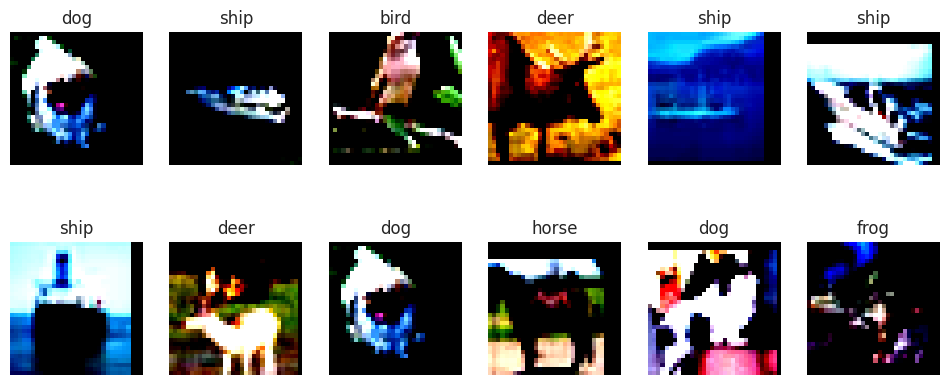

In [18]:
show_images_loader(trainloader, feature_names=feature_names)

# Helper Functions

In [24]:
def create_model(lhl):  
    
    # model
    model_setup['last_hidden_neurons'] = lhl
    
    # torch 2.0 compile and parallel data training
    model = model_(**model_setup).to(device)
    model = torch.compile(model)
    nn.DataParallel(model, device_ids=[CUDA])
    
    # loss function
    loss_function = nn.CrossEntropyLoss()
    
    # optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'], momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_config['epochs'])
    
    # model prefix and create folders
    POSTFIX = f"{type(optimizer).__name__}-{model_config['batch_size']}-{lhl}"
    
    return POSTFIX, model, loss_function, optimizer, scheduler

In [25]:
def create_folders(postfix):
    model_name = f'{DATASET}_{postfix}'
    paths = fetchPaths(base, DATASET, postfix)
    path_saved_model = paths['saved_models']
    path_lhl_raw = paths['lhl_raw']
    path_lhl_pca = paths['lhl_pca']
    
    return model_name, path_saved_model, path_lhl_raw, path_lhl_pca

In [26]:
def start_training_testing(model, loss_function, optimizer, scheduler):
    # training testing attributes
    kwargs = {
        'model': model,
        'loss_function': loss_function,
        'optimizer': optimizer,
        'lr_scheduler': scheduler,
        'map_classes': None,
        'skip_classes': None,
        'device': device,
        'model_path': path_saved_model / f"{DATASET}_{POSTFIX}.pth.tar",
        'trainloader': trainloader,
        'testloader': testloader,
        'config': model_config
    }

    # run training testing
    return run_training_testing(**kwargs)

In [27]:
def load_best_model(best_model):
    # create empty model
    model = model_(**model_setup).to(device)

    # load model
    load_checkpoint(model, best_model)
    
    return model

## Run Training

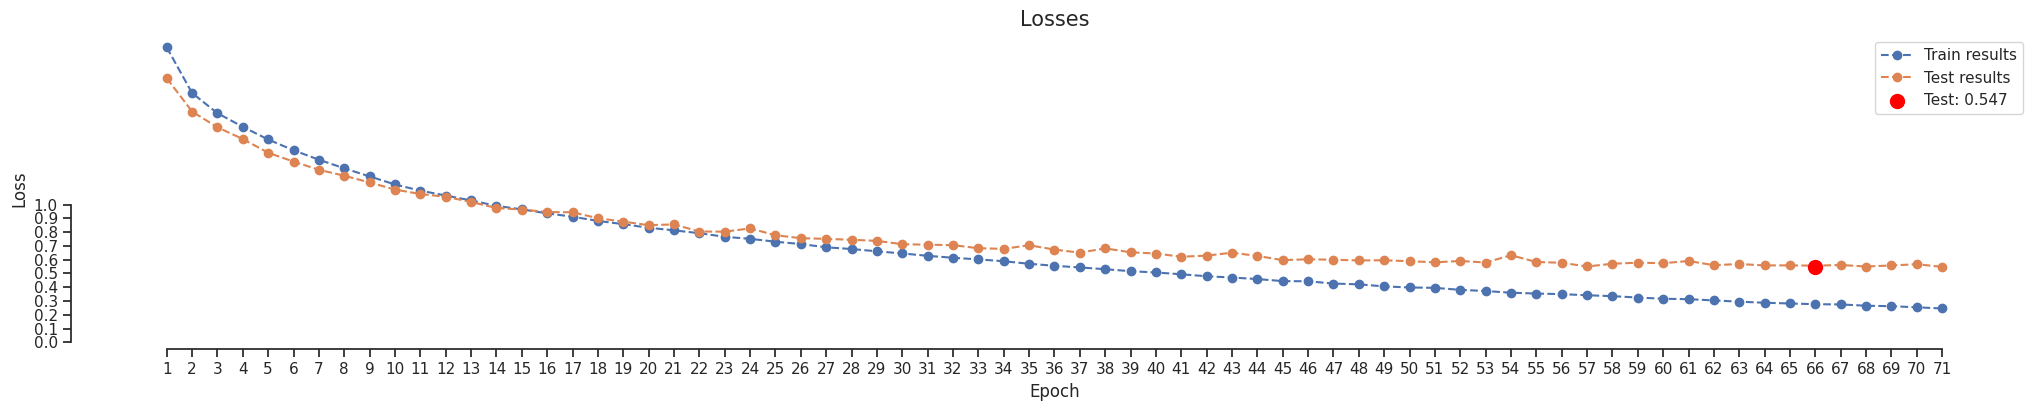

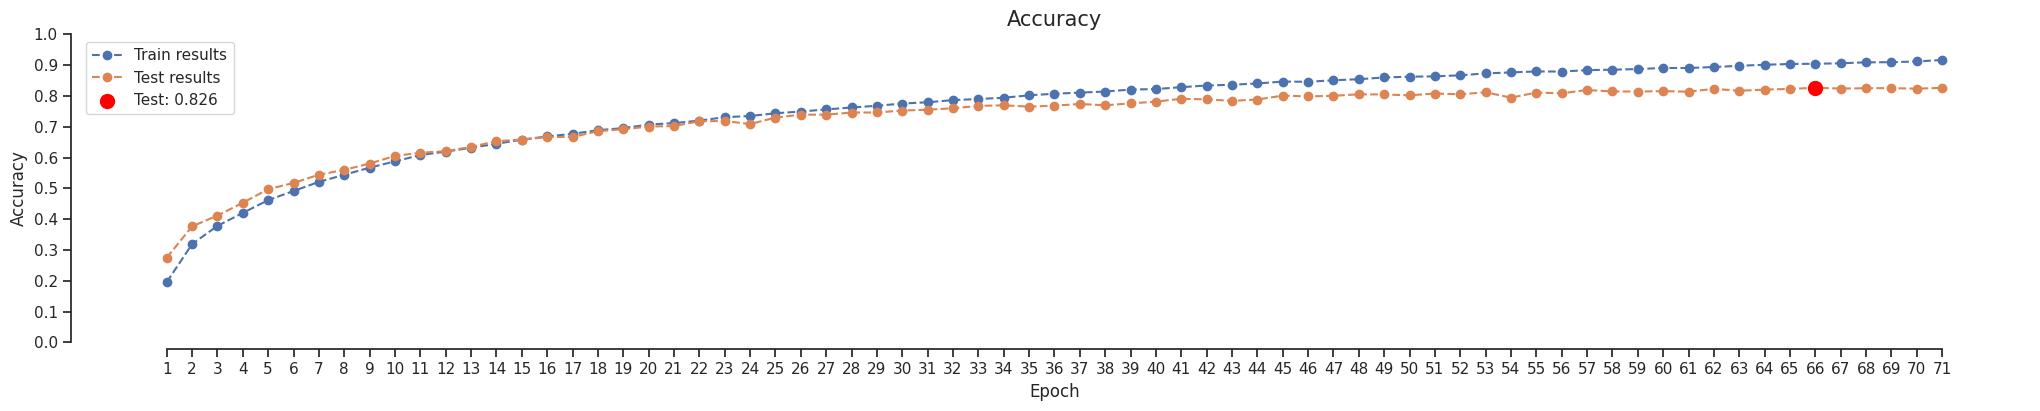

RuntimeError: Error(s) in loading state_dict for Cifar10_DLA:
	Missing key(s) in state_dict: "scaleInputs.weight", "scaleInputs.bias", "scaleInputs.running_mean", "scaleInputs.running_var", "base.0.weight", "base.1.weight", "base.1.bias", "base.1.running_mean", "base.1.running_var", "layer1.0.weight", "layer1.1.weight", "layer1.1.bias", "layer1.1.running_mean", "layer1.1.running_var", "layer2.0.weight", "layer2.1.weight", "layer2.1.bias", "layer2.1.running_mean", "layer2.1.running_var", "layer3.root.conv.weight", "layer3.root.bn.weight", "layer3.root.bn.bias", "layer3.root.bn.running_mean", "layer3.root.bn.running_var", "layer3.left_tree.conv1.weight", "layer3.left_tree.bn1.weight", "layer3.left_tree.bn1.bias", "layer3.left_tree.bn1.running_mean", "layer3.left_tree.bn1.running_var", "layer3.left_tree.conv2.weight", "layer3.left_tree.bn2.weight", "layer3.left_tree.bn2.bias", "layer3.left_tree.bn2.running_mean", "layer3.left_tree.bn2.running_var", "layer3.left_tree.shortcut.0.weight", "layer3.left_tree.shortcut.1.weight", "layer3.left_tree.shortcut.1.bias", "layer3.left_tree.shortcut.1.running_mean", "layer3.left_tree.shortcut.1.running_var", "layer3.right_tree.conv1.weight", "layer3.right_tree.bn1.weight", "layer3.right_tree.bn1.bias", "layer3.right_tree.bn1.running_mean", "layer3.right_tree.bn1.running_var", "layer3.right_tree.conv2.weight", "layer3.right_tree.bn2.weight", "layer3.right_tree.bn2.bias", "layer3.right_tree.bn2.running_mean", "layer3.right_tree.bn2.running_var", "layer4.root.conv.weight", "layer4.root.bn.weight", "layer4.root.bn.bias", "layer4.root.bn.running_mean", "layer4.root.bn.running_var", "layer4.left_tree.root.conv.weight", "layer4.left_tree.root.bn.weight", "layer4.left_tree.root.bn.bias", "layer4.left_tree.root.bn.running_mean", "layer4.left_tree.root.bn.running_var", "layer4.left_tree.left_tree.conv1.weight", "layer4.left_tree.left_tree.bn1.weight", "layer4.left_tree.left_tree.bn1.bias", "layer4.left_tree.left_tree.bn1.running_mean", "layer4.left_tree.left_tree.bn1.running_var", "layer4.left_tree.left_tree.conv2.weight", "layer4.left_tree.left_tree.bn2.weight", "layer4.left_tree.left_tree.bn2.bias", "layer4.left_tree.left_tree.bn2.running_mean", "layer4.left_tree.left_tree.bn2.running_var", "layer4.left_tree.left_tree.shortcut.0.weight", "layer4.left_tree.left_tree.shortcut.1.weight", "layer4.left_tree.left_tree.shortcut.1.bias", "layer4.left_tree.left_tree.shortcut.1.running_mean", "layer4.left_tree.left_tree.shortcut.1.running_var", "layer4.left_tree.right_tree.conv1.weight", "layer4.left_tree.right_tree.bn1.weight", "layer4.left_tree.right_tree.bn1.bias", "layer4.left_tree.right_tree.bn1.running_mean", "layer4.left_tree.right_tree.bn1.running_var", "layer4.left_tree.right_tree.conv2.weight", "layer4.left_tree.right_tree.bn2.weight", "layer4.left_tree.right_tree.bn2.bias", "layer4.left_tree.right_tree.bn2.running_mean", "layer4.left_tree.right_tree.bn2.running_var", "layer4.right_tree.root.conv.weight", "layer4.right_tree.root.bn.weight", "layer4.right_tree.root.bn.bias", "layer4.right_tree.root.bn.running_mean", "layer4.right_tree.root.bn.running_var", "layer4.right_tree.left_tree.conv1.weight", "layer4.right_tree.left_tree.bn1.weight", "layer4.right_tree.left_tree.bn1.bias", "layer4.right_tree.left_tree.bn1.running_mean", "layer4.right_tree.left_tree.bn1.running_var", "layer4.right_tree.left_tree.conv2.weight", "layer4.right_tree.left_tree.bn2.weight", "layer4.right_tree.left_tree.bn2.bias", "layer4.right_tree.left_tree.bn2.running_mean", "layer4.right_tree.left_tree.bn2.running_var", "layer4.right_tree.right_tree.conv1.weight", "layer4.right_tree.right_tree.bn1.weight", "layer4.right_tree.right_tree.bn1.bias", "layer4.right_tree.right_tree.bn1.running_mean", "layer4.right_tree.right_tree.bn1.running_var", "layer4.right_tree.right_tree.conv2.weight", "layer4.right_tree.right_tree.bn2.weight", "layer4.right_tree.right_tree.bn2.bias", "layer4.right_tree.right_tree.bn2.running_mean", "layer4.right_tree.right_tree.bn2.running_var", "layer5.root.conv.weight", "layer5.root.bn.weight", "layer5.root.bn.bias", "layer5.root.bn.running_mean", "layer5.root.bn.running_var", "layer5.left_tree.root.conv.weight", "layer5.left_tree.root.bn.weight", "layer5.left_tree.root.bn.bias", "layer5.left_tree.root.bn.running_mean", "layer5.left_tree.root.bn.running_var", "layer5.left_tree.left_tree.conv1.weight", "layer5.left_tree.left_tree.bn1.weight", "layer5.left_tree.left_tree.bn1.bias", "layer5.left_tree.left_tree.bn1.running_mean", "layer5.left_tree.left_tree.bn1.running_var", "layer5.left_tree.left_tree.conv2.weight", "layer5.left_tree.left_tree.bn2.weight", "layer5.left_tree.left_tree.bn2.bias", "layer5.left_tree.left_tree.bn2.running_mean", "layer5.left_tree.left_tree.bn2.running_var", "layer5.left_tree.left_tree.shortcut.0.weight", "layer5.left_tree.left_tree.shortcut.1.weight", "layer5.left_tree.left_tree.shortcut.1.bias", "layer5.left_tree.left_tree.shortcut.1.running_mean", "layer5.left_tree.left_tree.shortcut.1.running_var", "layer5.left_tree.right_tree.conv1.weight", "layer5.left_tree.right_tree.bn1.weight", "layer5.left_tree.right_tree.bn1.bias", "layer5.left_tree.right_tree.bn1.running_mean", "layer5.left_tree.right_tree.bn1.running_var", "layer5.left_tree.right_tree.conv2.weight", "layer5.left_tree.right_tree.bn2.weight", "layer5.left_tree.right_tree.bn2.bias", "layer5.left_tree.right_tree.bn2.running_mean", "layer5.left_tree.right_tree.bn2.running_var", "layer5.right_tree.root.conv.weight", "layer5.right_tree.root.bn.weight", "layer5.right_tree.root.bn.bias", "layer5.right_tree.root.bn.running_mean", "layer5.right_tree.root.bn.running_var", "layer5.right_tree.left_tree.conv1.weight", "layer5.right_tree.left_tree.bn1.weight", "layer5.right_tree.left_tree.bn1.bias", "layer5.right_tree.left_tree.bn1.running_mean", "layer5.right_tree.left_tree.bn1.running_var", "layer5.right_tree.left_tree.conv2.weight", "layer5.right_tree.left_tree.bn2.weight", "layer5.right_tree.left_tree.bn2.bias", "layer5.right_tree.left_tree.bn2.running_mean", "layer5.right_tree.left_tree.bn2.running_var", "layer5.right_tree.right_tree.conv1.weight", "layer5.right_tree.right_tree.bn1.weight", "layer5.right_tree.right_tree.bn1.bias", "layer5.right_tree.right_tree.bn1.running_mean", "layer5.right_tree.right_tree.bn1.running_var", "layer5.right_tree.right_tree.conv2.weight", "layer5.right_tree.right_tree.bn2.weight", "layer5.right_tree.right_tree.bn2.bias", "layer5.right_tree.right_tree.bn2.running_mean", "layer5.right_tree.right_tree.bn2.running_var", "layer6.root.conv.weight", "layer6.root.bn.weight", "layer6.root.bn.bias", "layer6.root.bn.running_mean", "layer6.root.bn.running_var", "layer6.left_tree.conv1.weight", "layer6.left_tree.bn1.weight", "layer6.left_tree.bn1.bias", "layer6.left_tree.bn1.running_mean", "layer6.left_tree.bn1.running_var", "layer6.left_tree.conv2.weight", "layer6.left_tree.bn2.weight", "layer6.left_tree.bn2.bias", "layer6.left_tree.bn2.running_mean", "layer6.left_tree.bn2.running_var", "layer6.left_tree.shortcut.0.weight", "layer6.left_tree.shortcut.1.weight", "layer6.left_tree.shortcut.1.bias", "layer6.left_tree.shortcut.1.running_mean", "layer6.left_tree.shortcut.1.running_var", "layer6.right_tree.conv1.weight", "layer6.right_tree.bn1.weight", "layer6.right_tree.bn1.bias", "layer6.right_tree.bn1.running_mean", "layer6.right_tree.bn1.running_var", "layer6.right_tree.conv2.weight", "layer6.right_tree.bn2.weight", "layer6.right_tree.bn2.bias", "layer6.right_tree.bn2.running_mean", "layer6.right_tree.bn2.running_var", "linear.weight", "linear.bias", "bn.weight", "bn.bias", "bn.running_mean", "bn.running_var", "output.weight", "output.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.scaleInputs.weight", "_orig_mod.scaleInputs.bias", "_orig_mod.scaleInputs.running_mean", "_orig_mod.scaleInputs.running_var", "_orig_mod.scaleInputs.num_batches_tracked", "_orig_mod.base.0.weight", "_orig_mod.base.1.weight", "_orig_mod.base.1.bias", "_orig_mod.base.1.running_mean", "_orig_mod.base.1.running_var", "_orig_mod.base.1.num_batches_tracked", "_orig_mod.layer1.0.weight", "_orig_mod.layer1.1.weight", "_orig_mod.layer1.1.bias", "_orig_mod.layer1.1.running_mean", "_orig_mod.layer1.1.running_var", "_orig_mod.layer1.1.num_batches_tracked", "_orig_mod.layer2.0.weight", "_orig_mod.layer2.1.weight", "_orig_mod.layer2.1.bias", "_orig_mod.layer2.1.running_mean", "_orig_mod.layer2.1.running_var", "_orig_mod.layer2.1.num_batches_tracked", "_orig_mod.layer3.root.conv.weight", "_orig_mod.layer3.root.bn.weight", "_orig_mod.layer3.root.bn.bias", "_orig_mod.layer3.root.bn.running_mean", "_orig_mod.layer3.root.bn.running_var", "_orig_mod.layer3.root.bn.num_batches_tracked", "_orig_mod.layer3.left_tree.conv1.weight", "_orig_mod.layer3.left_tree.bn1.weight", "_orig_mod.layer3.left_tree.bn1.bias", "_orig_mod.layer3.left_tree.bn1.running_mean", "_orig_mod.layer3.left_tree.bn1.running_var", "_orig_mod.layer3.left_tree.bn1.num_batches_tracked", "_orig_mod.layer3.left_tree.conv2.weight", "_orig_mod.layer3.left_tree.bn2.weight", "_orig_mod.layer3.left_tree.bn2.bias", "_orig_mod.layer3.left_tree.bn2.running_mean", "_orig_mod.layer3.left_tree.bn2.running_var", "_orig_mod.layer3.left_tree.bn2.num_batches_tracked", "_orig_mod.layer3.left_tree.shortcut.0.weight", "_orig_mod.layer3.left_tree.shortcut.1.weight", "_orig_mod.layer3.left_tree.shortcut.1.bias", "_orig_mod.layer3.left_tree.shortcut.1.running_mean", "_orig_mod.layer3.left_tree.shortcut.1.running_var", "_orig_mod.layer3.left_tree.shortcut.1.num_batches_tracked", "_orig_mod.layer3.right_tree.conv1.weight", "_orig_mod.layer3.right_tree.bn1.weight", "_orig_mod.layer3.right_tree.bn1.bias", "_orig_mod.layer3.right_tree.bn1.running_mean", "_orig_mod.layer3.right_tree.bn1.running_var", "_orig_mod.layer3.right_tree.bn1.num_batches_tracked", "_orig_mod.layer3.right_tree.conv2.weight", "_orig_mod.layer3.right_tree.bn2.weight", "_orig_mod.layer3.right_tree.bn2.bias", "_orig_mod.layer3.right_tree.bn2.running_mean", "_orig_mod.layer3.right_tree.bn2.running_var", "_orig_mod.layer3.right_tree.bn2.num_batches_tracked", "_orig_mod.layer4.root.conv.weight", "_orig_mod.layer4.root.bn.weight", "_orig_mod.layer4.root.bn.bias", "_orig_mod.layer4.root.bn.running_mean", "_orig_mod.layer4.root.bn.running_var", "_orig_mod.layer4.root.bn.num_batches_tracked", "_orig_mod.layer4.left_tree.root.conv.weight", "_orig_mod.layer4.left_tree.root.bn.weight", "_orig_mod.layer4.left_tree.root.bn.bias", "_orig_mod.layer4.left_tree.root.bn.running_mean", "_orig_mod.layer4.left_tree.root.bn.running_var", "_orig_mod.layer4.left_tree.root.bn.num_batches_tracked", "_orig_mod.layer4.left_tree.left_tree.conv1.weight", "_orig_mod.layer4.left_tree.left_tree.bn1.weight", "_orig_mod.layer4.left_tree.left_tree.bn1.bias", "_orig_mod.layer4.left_tree.left_tree.bn1.running_mean", "_orig_mod.layer4.left_tree.left_tree.bn1.running_var", "_orig_mod.layer4.left_tree.left_tree.bn1.num_batches_tracked", "_orig_mod.layer4.left_tree.left_tree.conv2.weight", "_orig_mod.layer4.left_tree.left_tree.bn2.weight", "_orig_mod.layer4.left_tree.left_tree.bn2.bias", "_orig_mod.layer4.left_tree.left_tree.bn2.running_mean", "_orig_mod.layer4.left_tree.left_tree.bn2.running_var", "_orig_mod.layer4.left_tree.left_tree.bn2.num_batches_tracked", "_orig_mod.layer4.left_tree.left_tree.shortcut.0.weight", "_orig_mod.layer4.left_tree.left_tree.shortcut.1.weight", "_orig_mod.layer4.left_tree.left_tree.shortcut.1.bias", "_orig_mod.layer4.left_tree.left_tree.shortcut.1.running_mean", "_orig_mod.layer4.left_tree.left_tree.shortcut.1.running_var", "_orig_mod.layer4.left_tree.left_tree.shortcut.1.num_batches_tracked", "_orig_mod.layer4.left_tree.right_tree.conv1.weight", "_orig_mod.layer4.left_tree.right_tree.bn1.weight", "_orig_mod.layer4.left_tree.right_tree.bn1.bias", "_orig_mod.layer4.left_tree.right_tree.bn1.running_mean", "_orig_mod.layer4.left_tree.right_tree.bn1.running_var", "_orig_mod.layer4.left_tree.right_tree.bn1.num_batches_tracked", "_orig_mod.layer4.left_tree.right_tree.conv2.weight", "_orig_mod.layer4.left_tree.right_tree.bn2.weight", "_orig_mod.layer4.left_tree.right_tree.bn2.bias", "_orig_mod.layer4.left_tree.right_tree.bn2.running_mean", "_orig_mod.layer4.left_tree.right_tree.bn2.running_var", "_orig_mod.layer4.left_tree.right_tree.bn2.num_batches_tracked", "_orig_mod.layer4.right_tree.root.conv.weight", "_orig_mod.layer4.right_tree.root.bn.weight", "_orig_mod.layer4.right_tree.root.bn.bias", "_orig_mod.layer4.right_tree.root.bn.running_mean", "_orig_mod.layer4.right_tree.root.bn.running_var", "_orig_mod.layer4.right_tree.root.bn.num_batches_tracked", "_orig_mod.layer4.right_tree.left_tree.conv1.weight", "_orig_mod.layer4.right_tree.left_tree.bn1.weight", "_orig_mod.layer4.right_tree.left_tree.bn1.bias", "_orig_mod.layer4.right_tree.left_tree.bn1.running_mean", "_orig_mod.layer4.right_tree.left_tree.bn1.running_var", "_orig_mod.layer4.right_tree.left_tree.bn1.num_batches_tracked", "_orig_mod.layer4.right_tree.left_tree.conv2.weight", "_orig_mod.layer4.right_tree.left_tree.bn2.weight", "_orig_mod.layer4.right_tree.left_tree.bn2.bias", "_orig_mod.layer4.right_tree.left_tree.bn2.running_mean", "_orig_mod.layer4.right_tree.left_tree.bn2.running_var", "_orig_mod.layer4.right_tree.left_tree.bn2.num_batches_tracked", "_orig_mod.layer4.right_tree.right_tree.conv1.weight", "_orig_mod.layer4.right_tree.right_tree.bn1.weight", "_orig_mod.layer4.right_tree.right_tree.bn1.bias", "_orig_mod.layer4.right_tree.right_tree.bn1.running_mean", "_orig_mod.layer4.right_tree.right_tree.bn1.running_var", "_orig_mod.layer4.right_tree.right_tree.bn1.num_batches_tracked", "_orig_mod.layer4.right_tree.right_tree.conv2.weight", "_orig_mod.layer4.right_tree.right_tree.bn2.weight", "_orig_mod.layer4.right_tree.right_tree.bn2.bias", "_orig_mod.layer4.right_tree.right_tree.bn2.running_mean", "_orig_mod.layer4.right_tree.right_tree.bn2.running_var", "_orig_mod.layer4.right_tree.right_tree.bn2.num_batches_tracked", "_orig_mod.layer5.root.conv.weight", "_orig_mod.layer5.root.bn.weight", "_orig_mod.layer5.root.bn.bias", "_orig_mod.layer5.root.bn.running_mean", "_orig_mod.layer5.root.bn.running_var", "_orig_mod.layer5.root.bn.num_batches_tracked", "_orig_mod.layer5.left_tree.root.conv.weight", "_orig_mod.layer5.left_tree.root.bn.weight", "_orig_mod.layer5.left_tree.root.bn.bias", "_orig_mod.layer5.left_tree.root.bn.running_mean", "_orig_mod.layer5.left_tree.root.bn.running_var", "_orig_mod.layer5.left_tree.root.bn.num_batches_tracked", "_orig_mod.layer5.left_tree.left_tree.conv1.weight", "_orig_mod.layer5.left_tree.left_tree.bn1.weight", "_orig_mod.layer5.left_tree.left_tree.bn1.bias", "_orig_mod.layer5.left_tree.left_tree.bn1.running_mean", "_orig_mod.layer5.left_tree.left_tree.bn1.running_var", "_orig_mod.layer5.left_tree.left_tree.bn1.num_batches_tracked", "_orig_mod.layer5.left_tree.left_tree.conv2.weight", "_orig_mod.layer5.left_tree.left_tree.bn2.weight", "_orig_mod.layer5.left_tree.left_tree.bn2.bias", "_orig_mod.layer5.left_tree.left_tree.bn2.running_mean", "_orig_mod.layer5.left_tree.left_tree.bn2.running_var", "_orig_mod.layer5.left_tree.left_tree.bn2.num_batches_tracked", "_orig_mod.layer5.left_tree.left_tree.shortcut.0.weight", "_orig_mod.layer5.left_tree.left_tree.shortcut.1.weight", "_orig_mod.layer5.left_tree.left_tree.shortcut.1.bias", "_orig_mod.layer5.left_tree.left_tree.shortcut.1.running_mean", "_orig_mod.layer5.left_tree.left_tree.shortcut.1.running_var", "_orig_mod.layer5.left_tree.left_tree.shortcut.1.num_batches_tracked", "_orig_mod.layer5.left_tree.right_tree.conv1.weight", "_orig_mod.layer5.left_tree.right_tree.bn1.weight", "_orig_mod.layer5.left_tree.right_tree.bn1.bias", "_orig_mod.layer5.left_tree.right_tree.bn1.running_mean", "_orig_mod.layer5.left_tree.right_tree.bn1.running_var", "_orig_mod.layer5.left_tree.right_tree.bn1.num_batches_tracked", "_orig_mod.layer5.left_tree.right_tree.conv2.weight", "_orig_mod.layer5.left_tree.right_tree.bn2.weight", "_orig_mod.layer5.left_tree.right_tree.bn2.bias", "_orig_mod.layer5.left_tree.right_tree.bn2.running_mean", "_orig_mod.layer5.left_tree.right_tree.bn2.running_var", "_orig_mod.layer5.left_tree.right_tree.bn2.num_batches_tracked", "_orig_mod.layer5.right_tree.root.conv.weight", "_orig_mod.layer5.right_tree.root.bn.weight", "_orig_mod.layer5.right_tree.root.bn.bias", "_orig_mod.layer5.right_tree.root.bn.running_mean", "_orig_mod.layer5.right_tree.root.bn.running_var", "_orig_mod.layer5.right_tree.root.bn.num_batches_tracked", "_orig_mod.layer5.right_tree.left_tree.conv1.weight", "_orig_mod.layer5.right_tree.left_tree.bn1.weight", "_orig_mod.layer5.right_tree.left_tree.bn1.bias", "_orig_mod.layer5.right_tree.left_tree.bn1.running_mean", "_orig_mod.layer5.right_tree.left_tree.bn1.running_var", "_orig_mod.layer5.right_tree.left_tree.bn1.num_batches_tracked", "_orig_mod.layer5.right_tree.left_tree.conv2.weight", "_orig_mod.layer5.right_tree.left_tree.bn2.weight", "_orig_mod.layer5.right_tree.left_tree.bn2.bias", "_orig_mod.layer5.right_tree.left_tree.bn2.running_mean", "_orig_mod.layer5.right_tree.left_tree.bn2.running_var", "_orig_mod.layer5.right_tree.left_tree.bn2.num_batches_tracked", "_orig_mod.layer5.right_tree.right_tree.conv1.weight", "_orig_mod.layer5.right_tree.right_tree.bn1.weight", "_orig_mod.layer5.right_tree.right_tree.bn1.bias", "_orig_mod.layer5.right_tree.right_tree.bn1.running_mean", "_orig_mod.layer5.right_tree.right_tree.bn1.running_var", "_orig_mod.layer5.right_tree.right_tree.bn1.num_batches_tracked", "_orig_mod.layer5.right_tree.right_tree.conv2.weight", "_orig_mod.layer5.right_tree.right_tree.bn2.weight", "_orig_mod.layer5.right_tree.right_tree.bn2.bias", "_orig_mod.layer5.right_tree.right_tree.bn2.running_mean", "_orig_mod.layer5.right_tree.right_tree.bn2.running_var", "_orig_mod.layer5.right_tree.right_tree.bn2.num_batches_tracked", "_orig_mod.layer6.root.conv.weight", "_orig_mod.layer6.root.bn.weight", "_orig_mod.layer6.root.bn.bias", "_orig_mod.layer6.root.bn.running_mean", "_orig_mod.layer6.root.bn.running_var", "_orig_mod.layer6.root.bn.num_batches_tracked", "_orig_mod.layer6.left_tree.conv1.weight", "_orig_mod.layer6.left_tree.bn1.weight", "_orig_mod.layer6.left_tree.bn1.bias", "_orig_mod.layer6.left_tree.bn1.running_mean", "_orig_mod.layer6.left_tree.bn1.running_var", "_orig_mod.layer6.left_tree.bn1.num_batches_tracked", "_orig_mod.layer6.left_tree.conv2.weight", "_orig_mod.layer6.left_tree.bn2.weight", "_orig_mod.layer6.left_tree.bn2.bias", "_orig_mod.layer6.left_tree.bn2.running_mean", "_orig_mod.layer6.left_tree.bn2.running_var", "_orig_mod.layer6.left_tree.bn2.num_batches_tracked", "_orig_mod.layer6.left_tree.shortcut.0.weight", "_orig_mod.layer6.left_tree.shortcut.1.weight", "_orig_mod.layer6.left_tree.shortcut.1.bias", "_orig_mod.layer6.left_tree.shortcut.1.running_mean", "_orig_mod.layer6.left_tree.shortcut.1.running_var", "_orig_mod.layer6.left_tree.shortcut.1.num_batches_tracked", "_orig_mod.layer6.right_tree.conv1.weight", "_orig_mod.layer6.right_tree.bn1.weight", "_orig_mod.layer6.right_tree.bn1.bias", "_orig_mod.layer6.right_tree.bn1.running_mean", "_orig_mod.layer6.right_tree.bn1.running_var", "_orig_mod.layer6.right_tree.bn1.num_batches_tracked", "_orig_mod.layer6.right_tree.conv2.weight", "_orig_mod.layer6.right_tree.bn2.weight", "_orig_mod.layer6.right_tree.bn2.bias", "_orig_mod.layer6.right_tree.bn2.running_mean", "_orig_mod.layer6.right_tree.bn2.running_var", "_orig_mod.layer6.right_tree.bn2.num_batches_tracked", "_orig_mod.linear.weight", "_orig_mod.linear.bias", "_orig_mod.bn.weight", "_orig_mod.bn.bias", "_orig_mod.bn.running_mean", "_orig_mod.bn.running_var", "_orig_mod.bn.num_batches_tracked", "_orig_mod.output.weight", "_orig_mod.output.bias". 

In [28]:
for lhl in bdd_configs['lhl_neurons']:

    POSTFIX, model, loss_function, optimizer, scheduler = create_model(lhl)
    model_name, path_saved_model, path_lhl_raw, path_lhl_pca = create_folders(POSTFIX)
    
    train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = \
    start_training_testing(model, loss_function, optimizer, scheduler)
    
    # load best model
    model = load_best_model(best_model_name)
    
    # normalize and save matrix
    confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
    save_confusion_matrix(confusion_matrix_test_norm, path_saved_model, model_name, 'test')
    
    # export last hidden layer data
    get_last_hidden_layer(trainloader, model, device, lhl, None, path_lhl_raw, model_name, 'train')
    get_last_hidden_layer(testloader, model, device, lhl, None, path_lhl_raw, model_name, 'test')

In [40]:
model = model_(**model_setup).to(device)
nn.DataParallel(model, device_ids=[CUDA])

;

''

In [38]:
best_model_name

PosixPath('/home/ah19/runtime-monitoring-2/experiments/Cifar10/saved-models/Cifar10_SGD-128-50/Cifar10_SGD-128-50-acc-0.826-loss-0.556.pth.tar')

In [42]:
# load model
model.load_state_dict(torch.load(best_model_name),strict=False)

_IncompatibleKeys(missing_keys=['scaleInputs.weight', 'scaleInputs.bias', 'scaleInputs.running_mean', 'scaleInputs.running_var', 'base.0.weight', 'base.1.weight', 'base.1.bias', 'base.1.running_mean', 'base.1.running_var', 'layer1.0.weight', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer2.0.weight', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer3.root.conv.weight', 'layer3.root.bn.weight', 'layer3.root.bn.bias', 'layer3.root.bn.running_mean', 'layer3.root.bn.running_var', 'layer3.left_tree.conv1.weight', 'layer3.left_tree.bn1.weight', 'layer3.left_tree.bn1.bias', 'layer3.left_tree.bn1.running_mean', 'layer3.left_tree.bn1.running_var', 'layer3.left_tree.conv2.weight', 'layer3.left_tree.bn2.weight', 'layer3.left_tree.bn2.bias', 'layer3.left_tree.bn2.running_mean', 'layer3.left_tree.bn2.running_var', 'layer3.left_tree.shortcut.0.weight', 'layer3.left_tree.shortcut.1.weight', 'layer3.left_tree.shortcu